# Analysis and simulations of evolutionary stable consortia

In [22]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import math
from functools import partial
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import string

%matplotlib inline

## Functions

### Trade-offs

In [4]:
class Species:
    def __init__(self, name):
        self.name = name
        self.color = 'b'
        self.legend = ''
        if self.name=='ecoli_exp':
            self.color = 'tab:blue'
            self.legend = r'$\it{E. coli}$ (experimental data)'
        if self.name=='ecoli_comp':
            self.color = 'tab:orange'
            self.legend = r'$\it{E. coli}$ (computational model)'
        if self.name=='ecoli_comp_an':
            self.color = 'tab:green'
            self.legend = r'$\it{E. coli}$ (comp model (anaerobic))'
        if self.name=='yeast_exp':
            self.color = 'tab:red'
            self.legend = r'$\it{S. cerevisiae}$ (experimental data)'
        if self.name=='yeast_comp':
            self.color = 'tab:purple'
            self.legend = r'$\it{S. cerevisiae}$ (computational model)'
        if self.name=='2_sp':
            self.color = 'tab:brown'
            self.legend = 'Combination of two species'
    def k(self, u):
        return 0.0005*10**(np.log10(10/0.0005)*u)
    def mu(self, u):
        if self.name=='ecoli_exp':
            return 1.23 * np.log(self.k(u)/(3.056*10**(-5)))/(np.log(self.k(u)/(3.056*10**(-5))) + 1)
        if self.name=='ecoli_comp':
            return (0.8*417**2.7)/((1/self.k(u))**2.7 + 417**2.7)
        if self.name=='ecoli_comp_an':
            return 0.1 * (self.k(u)/(self.k(u)+0.0039)) + 0.21 * (self.k(u)**5.6/(self.k(u)**5.6+0.023**5.6))
        if self.name=='yeast_exp':
            return 0.34 * self.k(u)/(0.77 + self.k(u))
        if self.name=='yeast_comp':
            return 0.67 * self.k(u)/(0.028 + self.k(u))
        if self.name=='2_sp':
            if hasattr(u, "__len__"):
                return [0.1 * (self.k(u)/(self.k(u)+0.0039)) + 0.21 * (self.k(u)**5.6/(self.k(u)**5.6+0.023**5.6)) if self.k(i) < 8.21074 else 0.34*self.k(u)/(0.77 + self.k(u)) for i in u] 
            else:
                if self.k(u) < 8.21074:
                    return 0.1 * (self.k(u)/(self.k(u)+0.0039)) + 0.21 * (self.k(u)**5.6/(self.k(u)**5.6+0.023**5.6))
                else:
                    return 0.34*self.k(u)/(0.77 + self.k(u))
    def y(self, u):
        if self.name=='ecoli_exp':
            if hasattr(u, "__len__"):
                return np.repeat(474, len(u))
            else:
                return 474
        if self.name=='ecoli_comp':
            return 495 * self.mu(u) / (0.0726 + self.mu(u))
        if self.name=='ecoli_comp_an':
            if hasattr(u, "__len__"):
                return np.repeat(40, len(u))
            else:
                return 40
        if self.name=='yeast_exp':
            return 7 * 0.3**10/(0.3**10 + self.mu(u)**10)
        if self.name=='yeast_comp':
            if hasattr(u, "__len__"):
                y_temp = np.repeat(3.7, len(u))
                y_temp[[self.mu(i) < 0.3 for i in u]] = 7.8
                return y_temp
            else:
                if self.mu(u) < 0.3:
                    return 7.8
                else:
                    return 3.7
        if self.name=='2_sp':
            if hasattr(u, "__len__"):
                return [40 if self.k(i) < 8.21074 else 7 * 0.3**10/(0.3**10 + self.mu(i)**10) for i in u] 
            else:
                if self.k(u) < 8.21074:
                    return 40
                else:
                    return 7 * 0.3**10/(0.3**10 + self.mu(u)**10)

In [5]:
class Two_species:
    def __init__(self, name):
        self.name = name
        self.color = 'b'
        self.legend = ''
        if self.name=='ecoli_exp':
            self.color = 'tab:blue'
            self.legend = r'$\it{E. coli}$ (experimental data)'
        if self.name=='ecoli_comp':
            self.color = 'tab:orange'
            self.legend = r'$\it{E. coli}$ (computational model)'
        if self.name=='ecoli_comp_an':
            self.color = 'tab:green'
            self.legend = r'$\it{E. coli}$ (comp model (anaerobic))'
        if self.name=='yeast_exp':
            self.color = 'tab:red'
            self.legend = r'$\it{S. cerevisiae}$ (experimental data)'
        if self.name=='yeast_comp':
            self.color = 'tab:purple'
            self.legend = r'$\it{S. cerevisiae}$ (computational model)'
        if self.name=='2_sp':
            self.color = 'tab:brown'
            self.legend = 'Combination of two species'
    def k(self, u):
        return 0.01*10**(np.log10(100/0.01)*u)
    def mu(self, u):
        if self.name=='ecoli_exp':
            return 1.23 * np.log(self.k(u)/(3.056*10**(-5)))/(np.log(self.k(u)/(3.056*10**(-5))) + 1)
        if self.name=='ecoli_comp':
            return (0.8*417**2.7)/((1/self.k(u))**2.7 + 417**2.7)
        if self.name=='ecoli_comp_an':
            return 0.1 * (self.k(u)/(self.k(u)+0.0039)) + 0.21 * (self.k(u)**5.6/(self.k(u)**5.6+0.023**5.6))
        if self.name=='yeast_exp':
            return 0.34 * self.k(u)/(0.77 + self.k(u))
        if self.name=='yeast_comp':
            return 0.67 * self.k(u)/(0.028 + self.k(u))
        if self.name=='2_sp':
            if hasattr(u, "__len__"):
                return [0.1 * (self.k(i)/(self.k(i)+0.0039)) + 0.21 * (self.k(i)**5.6/(self.k(i)**5.6+0.023**5.6)) if self.k(i) < 8.21074 else 0.34*self.k(i)/(0.77 + self.k(i)) for i in u] 
            else:
                if self.k(u) < 8.21074:
                    return 0.1 * (self.k(u)/(self.k(u)+0.0039)) + 0.21 * (self.k(u)**5.6/(self.k(u)**5.6+0.023**5.6))
                else:
                    return 0.34 * self.k(u)/(0.77 + self.k(u))
    def y(self, u):
        if self.name=='ecoli_exp':
            if hasattr(u, "__len__"):
                return np.repeat(474, len(u))
            else:
                return 474
        if self.name=='ecoli_comp':
            return 495 * self.mu(u) / (0.0726 + self.mu(u))
        if self.name=='ecoli_comp_an':
            if hasattr(u, "__len__"):
                return np.repeat(40, len(u))
            else:
                return 40
        if self.name=='yeast_exp':
            return 7 * 0.3**10/(0.3**10 + self.mu(u)**10)
        if self.name=='yeast_comp':
            if hasattr(u, "__len__"):
                y_temp = np.repeat(3.7, len(u))
                y_temp[[self.mu(i) < 0.3 for i in u]] = 7.8
                return y_temp
            else:
                if self.mu(u) < 0.3:
                    return 7.8
                else:
                    return 3.7
        if self.name=='2_sp':
            if hasattr(u, "__len__"):
                return [40 if self.k(i) < 8.21074 else 7 * 0.3**10/(0.3**10 + self.mu(i)**10) for i in u] 
            else:
                if self.k(u) < 8.21074:
                    return 40
                else:
                    return 7 * 0.3**10/(0.3**10 + self.mu(u)**10)

### Functions for calculations

Calculate a pairwise invasibility plot

In [6]:
def compute_pip(steps, s0, x0, sp, V=1):
    """Return 3 matrices of size step X step:
    R: Resident population trait (constant on each column, go from 0 to 1 in the first and last column).
    M: Mutant population trait (constant on each line, go from 0 to 1 between the first and last line)
    PIP: Corresponding invasion fitness."""
    
    # Fill the R, M matrices with linearly spaced values in [0, 1]. 
    R,M = np.meshgrid(np.linspace(0,1,steps),
                      np.linspace(0,1,steps))

    s = partial(invasion_fitness, s0=s0, x0=x0, sp=sp, V=V)
    s = np.frompyfunc(s, 2, 1)
    PIP = s(M, R)
    return R, M, PIP

Find the equilibria in a pairwise invasibility plot

In [7]:
def find_singular_trait_value(sp, s0, x0, min, max):
    f = lambda m: invasion_fitness(m,m+1e-5, sp=sp, s0=s0, x0=x0)
    r = scipy.optimize.brentq(f,min,max)
    return r


Plot the invasion fitness for all types for a certain resident type (with $u$ on the x-axis)

In [8]:
def plot_local_landscape(ax, r, sp, s0, x0):
    mlist = np.linspace(0,1,1000)
    slist = [invasion_fitness(m,r,sp=sp,s0=s0,x0=x0) for m in mlist]
    ax.plot(mlist,slist)
    ax.plot(mlist,[0]*len(mlist), '--', color='k', alpha=.5)
    ax.set(xlabel=r'$u_m$', ylabel=r'$\omega$')
    ax.scatter(r,0,color='C3')

Plot the invasion fitness for all types for a certain resident type (with $K_S$ on the x-axis)

In [9]:
def plot_local_landscape2(ax, r, sp, s0, x0):
    mlist = np.linspace(0,1,1000)
    slist = [invasion_fitness(m,r,sp=sp,s0=s0,x0=x0) for m in mlist]
    ax.plot(mlist,slist)
    ax.plot(mlist,[0]*len(mlist), '--', color='k', alpha=.5)
    ax.set_xticks([0,1])
    ax.set_xticklabels([0.01,100])
    ax.set(xlabel=r'$K_S$', ylabel=r'$\omega$')
    ax.scatter(r,0,color='C3')

Plot the invasion fitness for all types for a certain resident type (with empty axes)

In [46]:
def plot_local_landscape3(ax, r, sp, s0, x0):
    mlist = np.linspace(0,1,1000)
    slist = [invasion_fitness(m,r,sp=sp,s0=s0,x0=x0) for m in mlist]
    ax.plot(mlist,slist)
    ax.plot(mlist,[0]*len(mlist), '--', color='k', alpha=.5)
    ax.set_ylim(-0.05, 0.05)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.scatter(r,0,color='C3')

Equation for the invasion fitness

In [10]:
def invasion_fitness(m, r, s0, x0, sp, V=1):
    """Invasion fitness of a rare mutant type with trait m in a resident population with trait r"""
    return math.log(((sp.k(m) + s0)/sp.k(m))**((sp.mu(m)/sp.mu(r))*(sp.k(r) - sp.k(m))/(sp.k(m) + x0/sp.y(r) + s0))*((x0 + sp.y(r)*s0)/x0)**((sp.mu(m)/sp.mu(r))*(sp.k(r)+x0/sp.y(r)+s0)/(sp.k(m)+x0/sp.y(r)+s0)))/math.log((x0 + sp.y(r) * s0)/x0)-1

## General calculations and data

In [11]:
ecoli = [Species(x) for x in ('ecoli_exp','ecoli_comp','ecoli_comp_an')]

In [12]:
yeast = [Two_species(x) for x in ('yeast_exp','yeast_comp')]

In [13]:
two_species = [Two_species(x) for x in ('ecoli_comp_an', 'yeast_exp', '2_sp')]

## Create Main Text Figure 4

In [14]:
steps = 1000
R, M = np.meshgrid(np.linspace(0,1,steps),
                      np.linspace(0,1,steps))

In [15]:
single_species = [Species(x) for x in ('ecoli_exp','ecoli_comp','ecoli_comp_an', 'yeast_exp', 'yeast_comp')]

In [16]:
r_pc, m_pc, pip_pc = compute_pip(1000, 0.1375, .5, Species('ecoli_exp'))

In [17]:
equilibria_pc = find_singular_trait_value(ecoli[0], 0.1375, .5, 0, 1)

C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


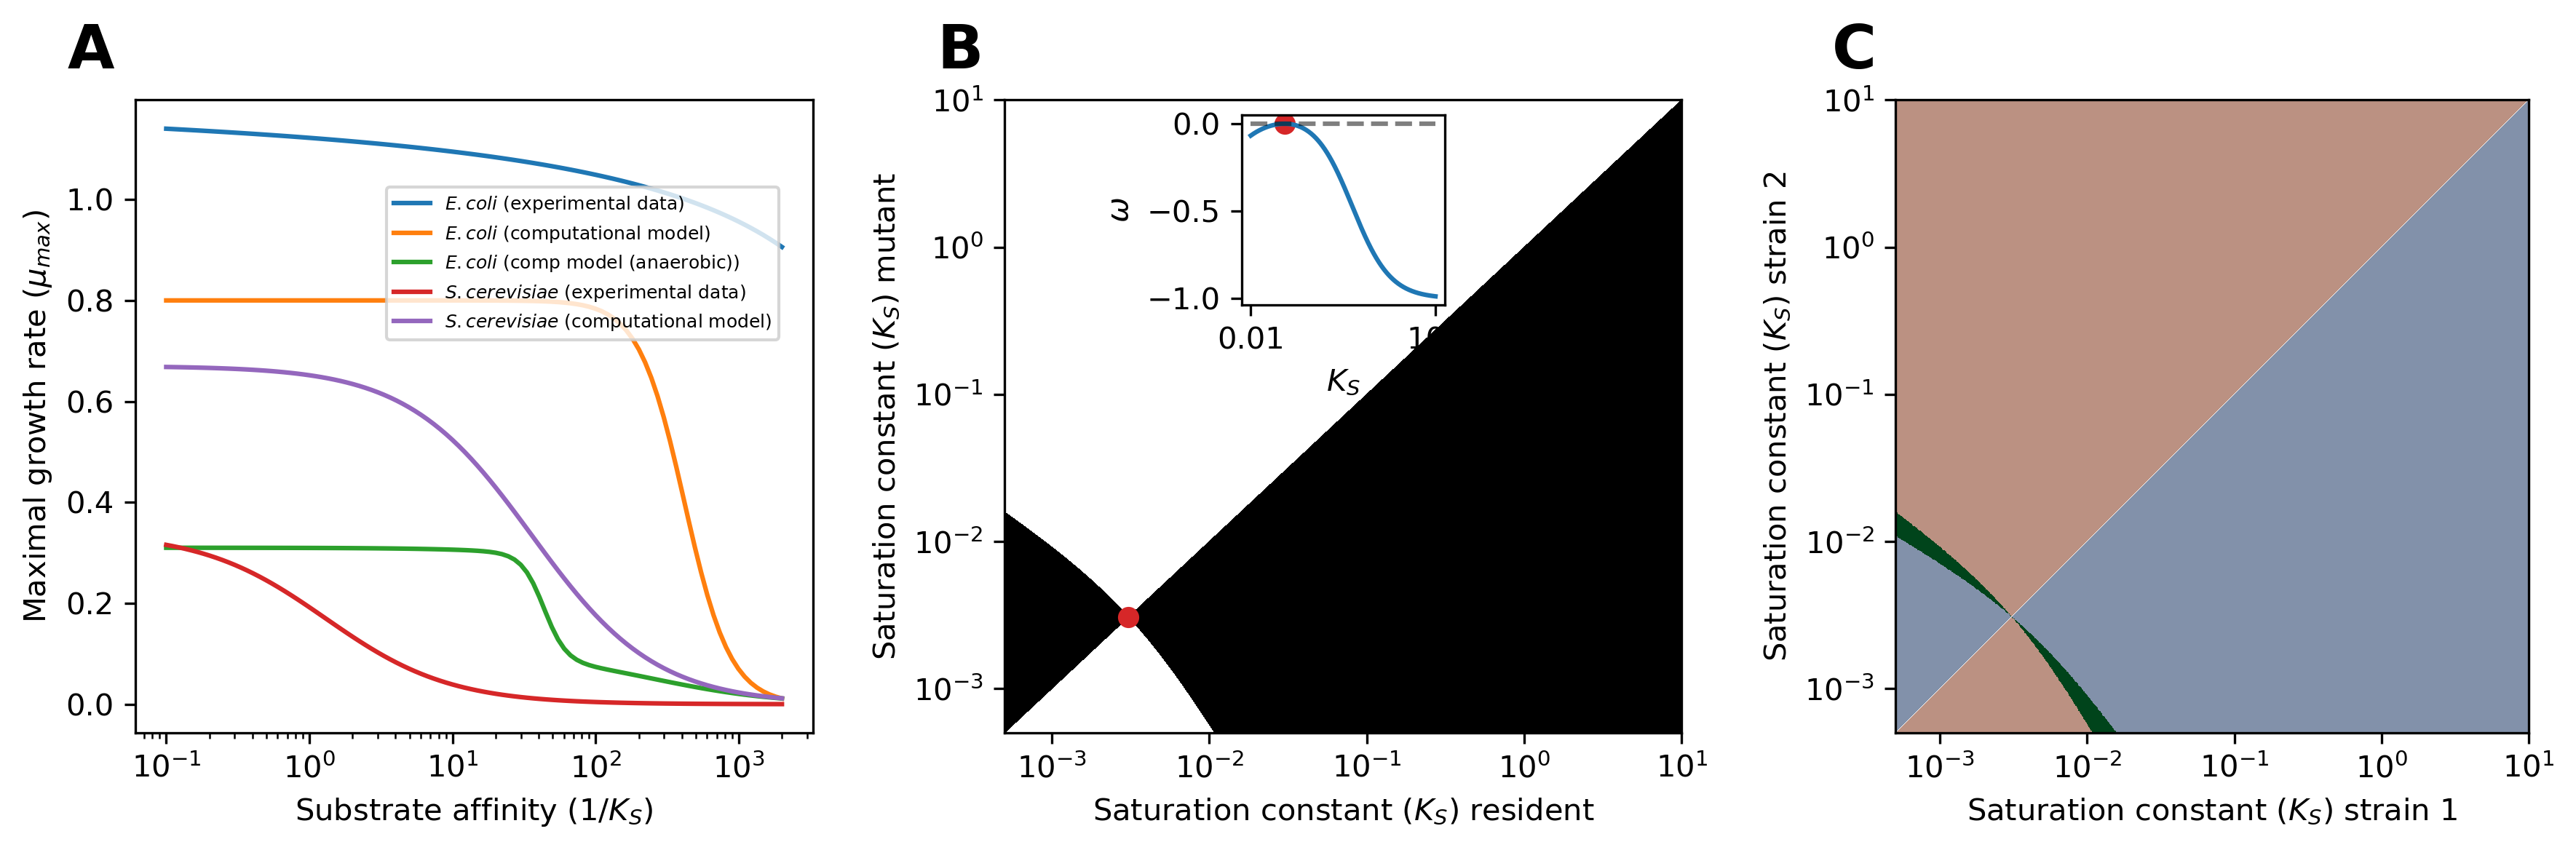

In [23]:
pip = pip_pc

tickvals = [np.log10(k/0.0005) / np.log10(10/0.0005) for k in [0.001, 0.01, 0.1, 1, 10]]
ticklabels = ['$10^{'  +str(i)+ '}$' for i in [-3, -2, -1, 0, 1]]
x = np.linspace(0,1,100)

fig, ax = plt.subplots(1,3, figsize=(12,4), dpi=300)

for sp in single_species:
    ax[0].plot(1/sp.k(x), sp.mu(x), color=sp.color)
ax[0].set_xscale('log')
ax[0].set(xlabel=r'Substrate affinity $(1/K_S)$', ylabel=r'Maximal growth rate $(\mu_{max})$')

fig.legend([sp.legend for sp in single_species], loc=(.15,.6), prop={'size': 6})

ax[1].contourf(r_pc, m_pc, pip, levels=[pip.min(),0,pip.max()], colors=['w','k'])
ax[1].set_xticks(tickvals)
ax[1].set_xticklabels(ticklabels)
ax[1].set_yticks(tickvals)
ax[1].set_yticklabels(ticklabels)
ax[1].scatter(equilibria_pc,equilibria_pc,color='C3')
axinsset = inset_axes(ax[1], width="30%", height="30%", loc="upper center")
plot_local_landscape2(axinsset, equilibria_pc, ecoli[0], 0.1375, .5)
ax[1].set(ylabel=r'Saturation constant $(K_S)$ mutant', xlabel=r'Saturation constant $(K_S)$ resident')

ax[2].imshow(pip>0, cmap='Blues', origin='lower', interpolation='none', extent=[0,1,0,1])
ax[2].set_xticks(tickvals)
ax[2].set_xticklabels(ticklabels)
ax[2].set_yticks(tickvals)
ax[2].set_yticklabels(ticklabels)
ax[2].imshow(np.transpose(pip)>0, cmap='Oranges', origin='lower', interpolation='none', extent=[0,1,0,1],alpha=0.5)
tep = np.logical_and(np.transpose(pip)>0,pip>0)
tep = np.ma.masked_where(tep == 0, tep)
tep[0,0]=0
ax[2].imshow(tep, cmap='Greens', origin='lower', interpolation='none', extent=[0,1,0,1])
ax[2].set(ylabel=r'Saturation constant $(K_S)$ strain 2', xlabel=r'Saturation constant $(K_S)$ strain 1')

ax = ax.flat

for n, ax1 in enumerate(ax): 
    ax1.text(-0.1, 1.05, string.ascii_uppercase[n], transform=ax1.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
#plt.savefig('figures/all_trade_offs_pip_mip.png')

## Create Main Text Figures 5A and 5B

In [41]:
r2, m2, pip2 = compute_pip(100, 500, 1, Two_species('2_sp'))

In [43]:
rstar = [0.44623049915494734, 0.7285855750111951, 0.8004742813734166] 

C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


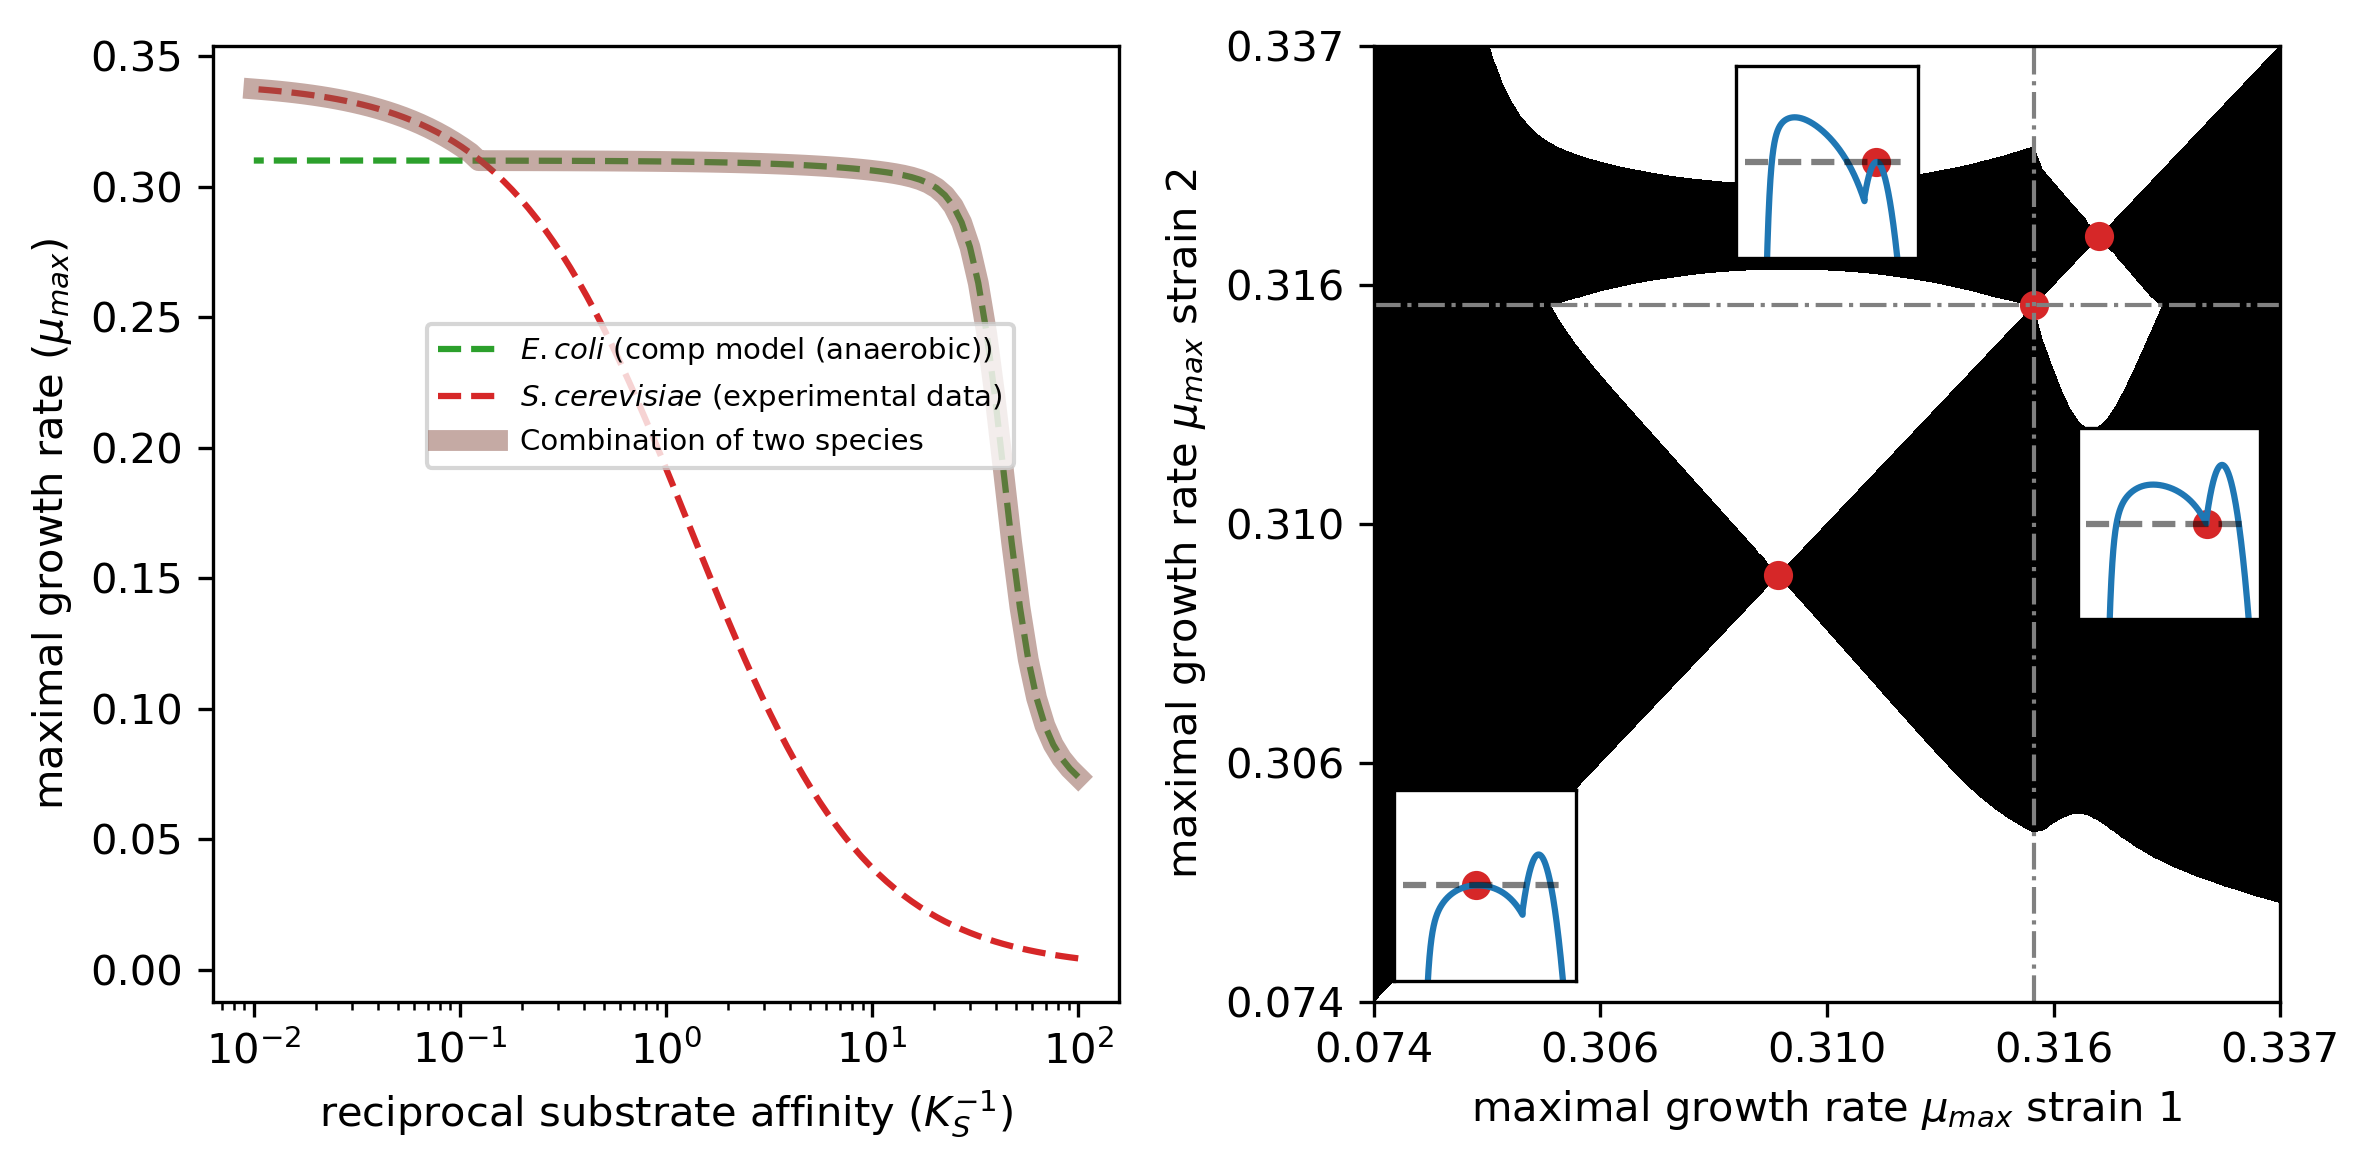

In [48]:
x = np.linspace(0,1,100)

tickvals = [np.log10(k/0.01) / np.log10(100/0.01) for k in [0.01, 0.1, 1, 10, 100]]
mus_tickvals = [Two_species('2_sp').mu(i) for i in tickvals]
ticklabels = ['{:.3f}'.format(i) for i in mus_tickvals]

fig,axs = plt.subplots(1,2, figsize=(8,4), dpi=300, gridspec_kw={'width_ratios': [1,1]})

for sp in two_species:
    if sp.name == '2_sp':
        axs[0].plot(1/sp.k(x), sp.mu(x), color=sp.color, linewidth=5, alpha=0.5)
    else:
        axs[0].plot(1/sp.k(x), sp.mu(x), '--',color=sp.color)
axs[0].set(xlabel=r'reciprocal substrate affinity $(K_S^{-1})$', ylabel=r'maximal growth rate $(\mu_{max})$')
axs[0].set_xscale('log')

fig.legend([sp.legend for sp in two_species], loc=(.18,.6), prop={'size': 7})

axs[1].contourf(r2, m2, pip2, levels=[pip2.min(),0,pip2.max()], colors=['w','k'])
axs[1].scatter(rstar[0],rstar[0],color='C3')
axs[1].scatter(rstar[1],rstar[1],color='C3')
axs[1].scatter(rstar[2],rstar[2],color='C3')
axs[1].set_xticks(tickvals)
axs[1].set_xticklabels(ticklabels)
axs[1].set_yticks(tickvals)
axs[1].set_yticklabels(ticklabels)
axinsset = inset_axes(axs[1], width="20%", height="20%", loc="lower left")
plot_local_landscape3(axinsset, rstar[0], two_species[2], 800, 150)
axinsset2 = inset_axes(axs[1], width="20%", height="20%", loc="center right")
plot_local_landscape3(axinsset2, rstar[1], two_species[2], 800, 150)
axinsset3 = inset_axes(axs[1], width="20%", height="20%", loc="upper center")
plot_local_landscape3(axinsset3, rstar[2], two_species[2], 800, 150)
axs[1].axvline(x=rstar[1], color='gray', ls='-.', lw='1')
axs[1].axhline(y=rstar[1], color='gray', ls='-.', lw='1')
axs[1].set(ylabel=r'maximal growth rate $\mu_{max}$ strain 2', xlabel=r'maximal growth rate $\mu_{max}$ strain 1')

axs = axs.flat

plt.tight_layout()
#plt.savefig('figures/2sp.svg')

## Create Appendix Figure A.3

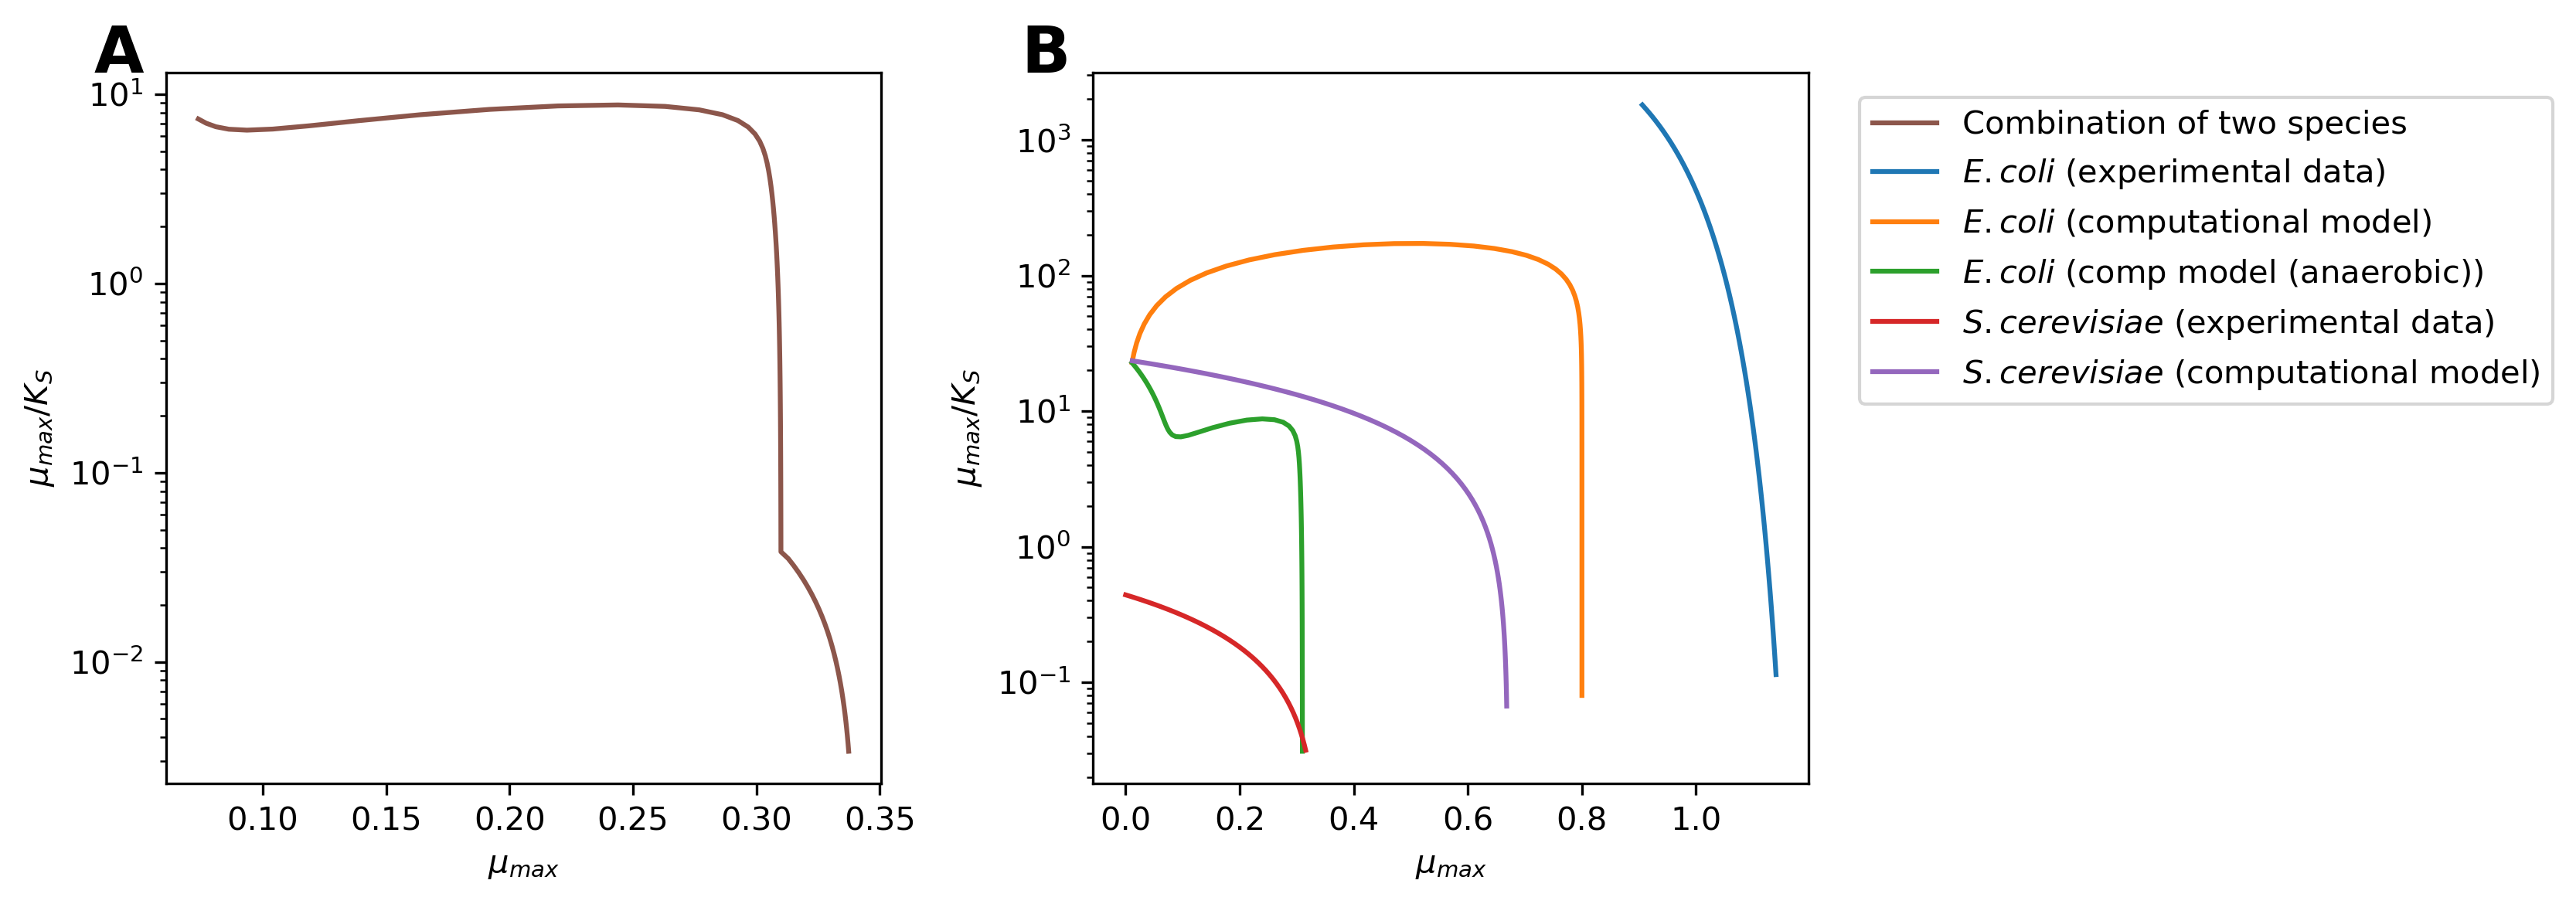

In [24]:
x = np.linspace(0,1,100)

fig,axs = plt.subplots(1,2, figsize=(8,4), dpi=300)

test_2_sp = Two_species('2_sp')

axs[0].plot(test_2_sp.mu(x), test_2_sp.mu(x)/test_2_sp.k(x), color=test_2_sp.color)
axs[0].set_yscale('log')
axs[0].set(xlabel=r'$\mu_{max}$', ylabel=r'$\mu_{max}/K_S$')

for sp in single_species:
    axs[1].plot(sp.mu(x), sp.mu(x)/sp.k(x), color=sp.color)
axs[1].set_yscale('log')
axs[1].set(xlabel=r'$\mu_{max}$', ylabel=r'$\mu_{max}/K_S$')

lgd = fig.legend([test_2_sp.legend]+[sp.legend for sp in single_species], bbox_to_anchor=(1, .9), loc='upper left')

axs = axs.flat

for n, ax in enumerate(axs): 
    text = ax.text(-0.1, 1.0, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
#plt.savefig('figures/all_trade_offs_mumax_over_ks.png')

## Create Appendix Figure A.4

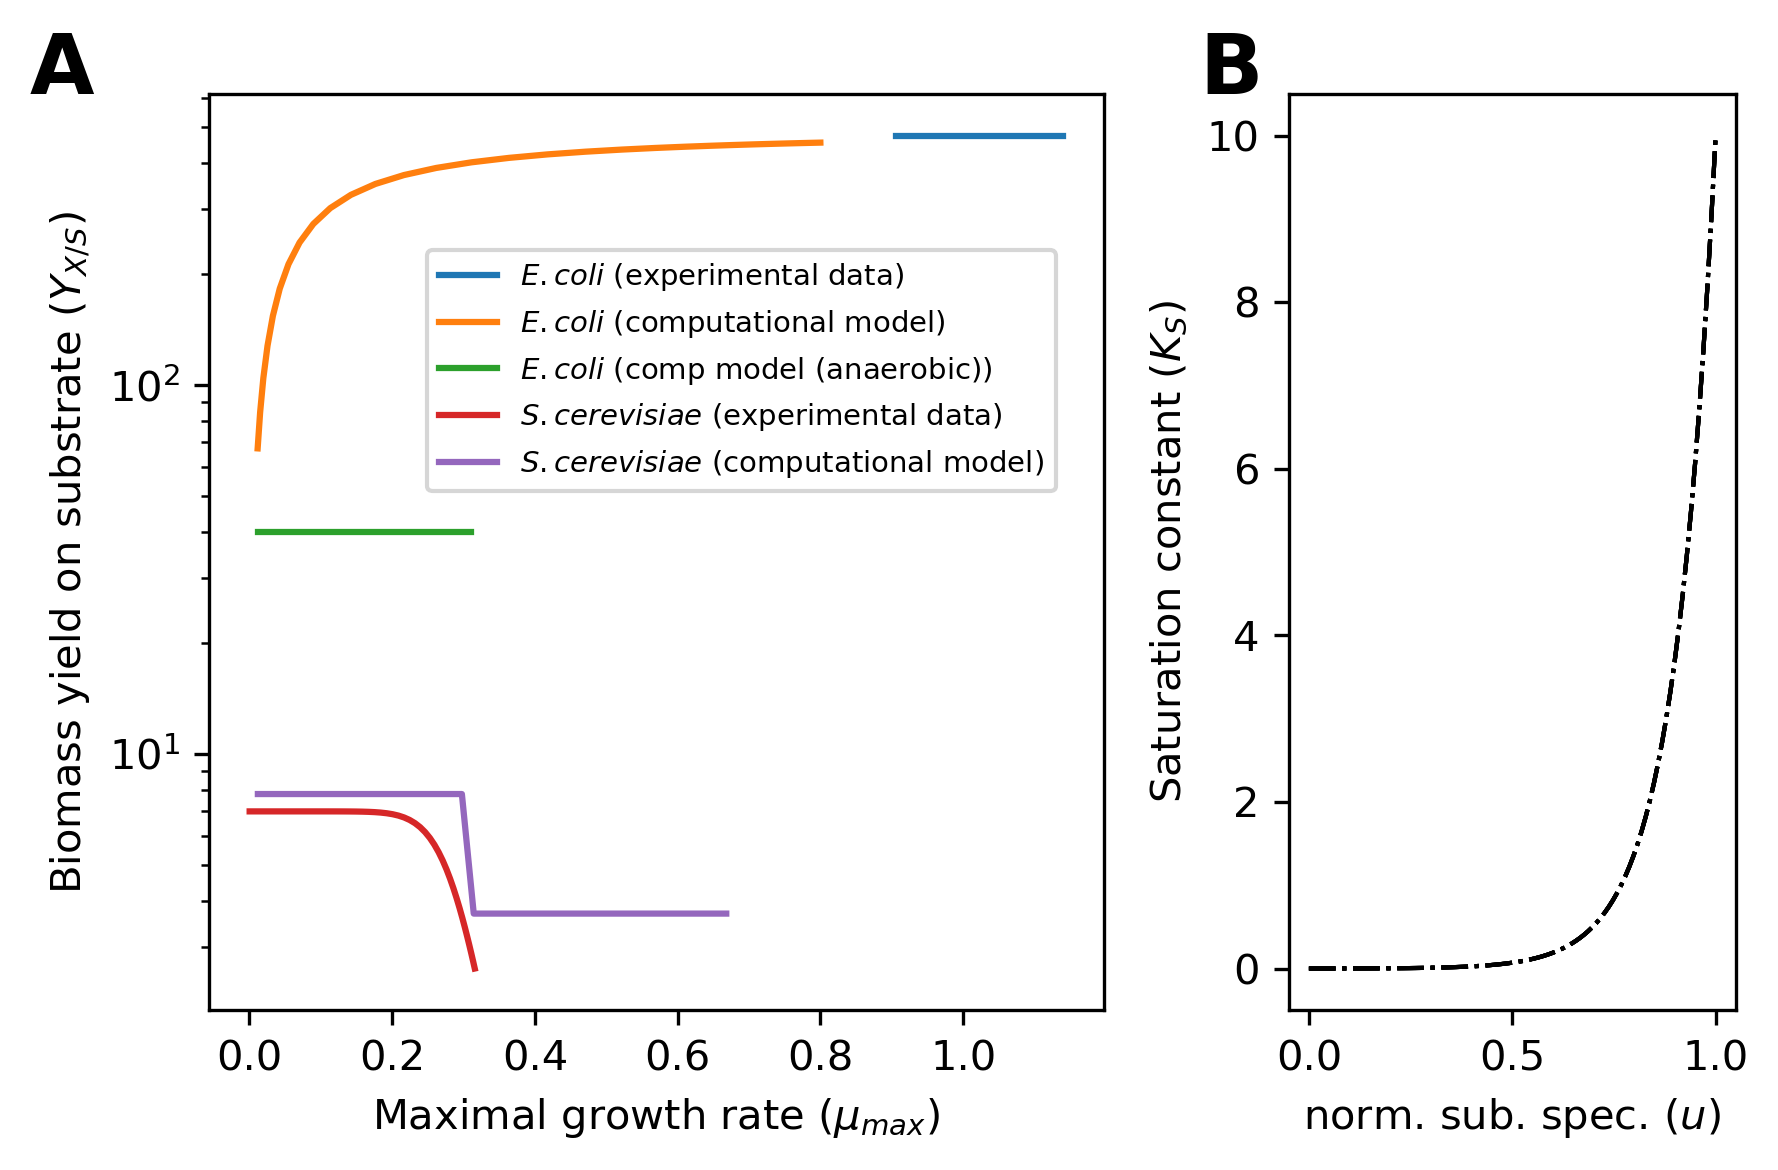

In [37]:
x = np.linspace(0,1,100)

fig,axs = plt.subplots(1,2, figsize=(6,4), dpi=300, gridspec_kw={'width_ratios': [2,1]})

for sp in single_species:
    axs[1].plot(x, sp.k(x), '-.', color='k', linewidth='1')
axs[1].set(xlabel=r'norm. sub. spec. $(u)$', ylabel=r'Saturation constant $(K_S)$')

for sp in single_species:
    axs[0].plot(sp.mu(x), sp.y(x), color=sp.color)
axs[0].set_yscale('log')
axs[0].set(xlabel=r'Maximal growth rate $(\mu_{max})$', ylabel=r'Biomass yield on substrate $(Y_{X/S})$')

fig.legend([sp.legend for sp in single_species], loc=(.24,.58), prop={'size': 7})

axs = axs.flat

for n, ax in enumerate(axs): 
    ax.text(-0.2, 1.0, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
#plt.savefig('figures/all_trade_offs_yield_u.png')

## Create Appendix Figure A.5

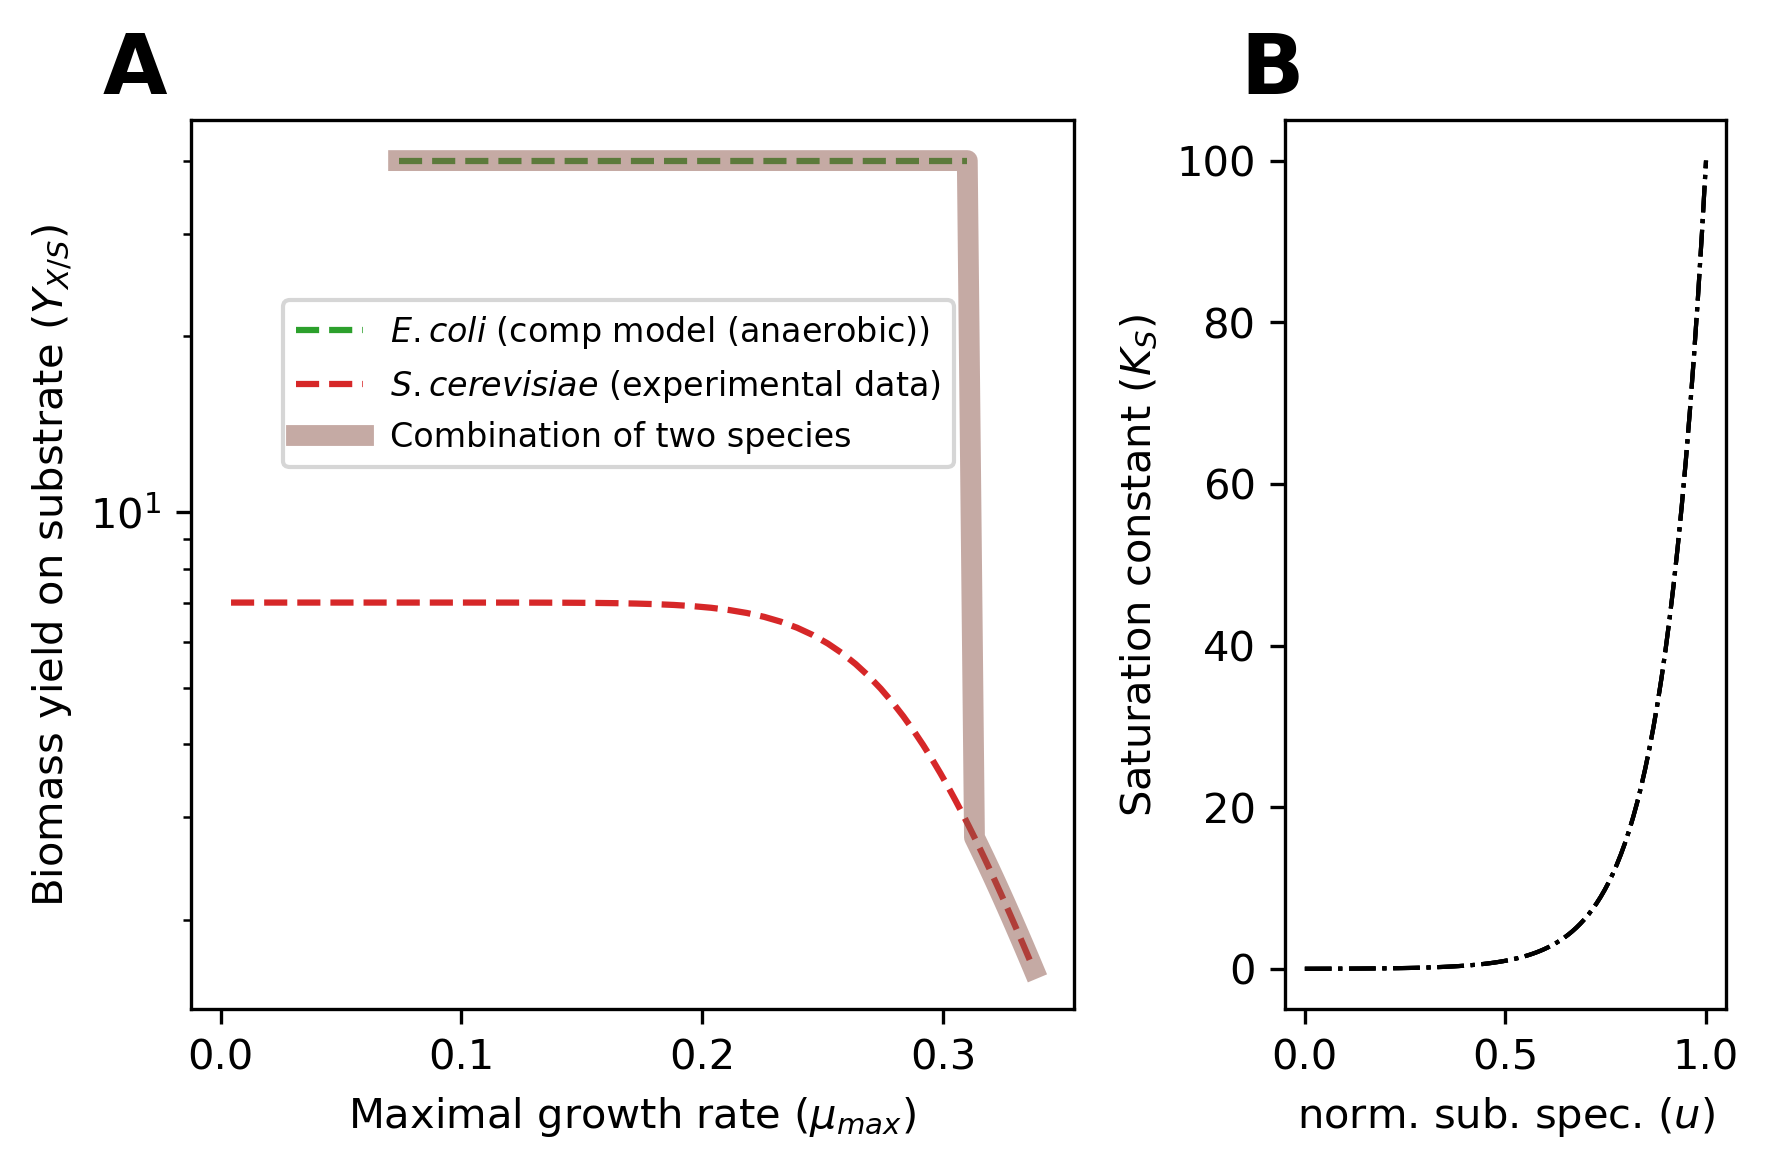

In [39]:
x = np.linspace(0,1,100)

fig,axs = plt.subplots(1,2, figsize=(6,4), dpi=300, gridspec_kw={'width_ratios': [2, 1]})

for sp in two_species:
    if sp.name == '2_sp':
        axs[0].plot(sp.mu(x), sp.y(x), color=sp.color, linewidth=5, alpha=0.5)
    else:
        axs[0].plot(sp.mu(x), sp.y(x), '--', color=sp.color)
axs[0].set_yscale('log')
axs[0].set(xlabel=r'Maximal growth rate $(\mu_{max})$', ylabel=r'Biomass yield on substrate $(Y_{X/S})$')

for sp in two_species:
    axs[1].plot(x, sp.k(x), '-.', color='k', linewidth='1')
axs[1].set(xlabel=r'norm. sub. spec. $(u)$', ylabel=r'Saturation constant $(K_S)$')

fig.legend([sp.legend for sp in two_species], loc=(.16,.6), prop={'size': 8})

for n, ax in enumerate(axs): 
    ax.text(-0.1, 1.03, string.ascii_uppercase[n], transform=ax.transAxes, 
            size=20, weight='bold')

plt.tight_layout()
#plt.savefig('figures/two_species_yield_u.png')

## Create Appendix Figures A.8 and A.9

In [27]:
pips_ecoli = []
for sp in ecoli:
    (_, _, temp) = compute_pip(1000, 0.1375, .5, sp)
    pips_ecoli.append(temp)
pips_yeast = []
for sp in yeast:
    (_, _, temp) = compute_pip(1000, 100, .1, sp)
    pips_yeast.append(temp)

In [28]:
equilibria_ecoli = []
for sp in ecoli:
    equilibria_ecoli.append(find_singular_trait_value(sp, 0.1375, .5, 0, 1))
equilibria_yeast = []
for sp in yeast:
    equilibria_yeast.append(find_singular_trait_value(sp, 100, .1, 0, 1))

C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:29: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


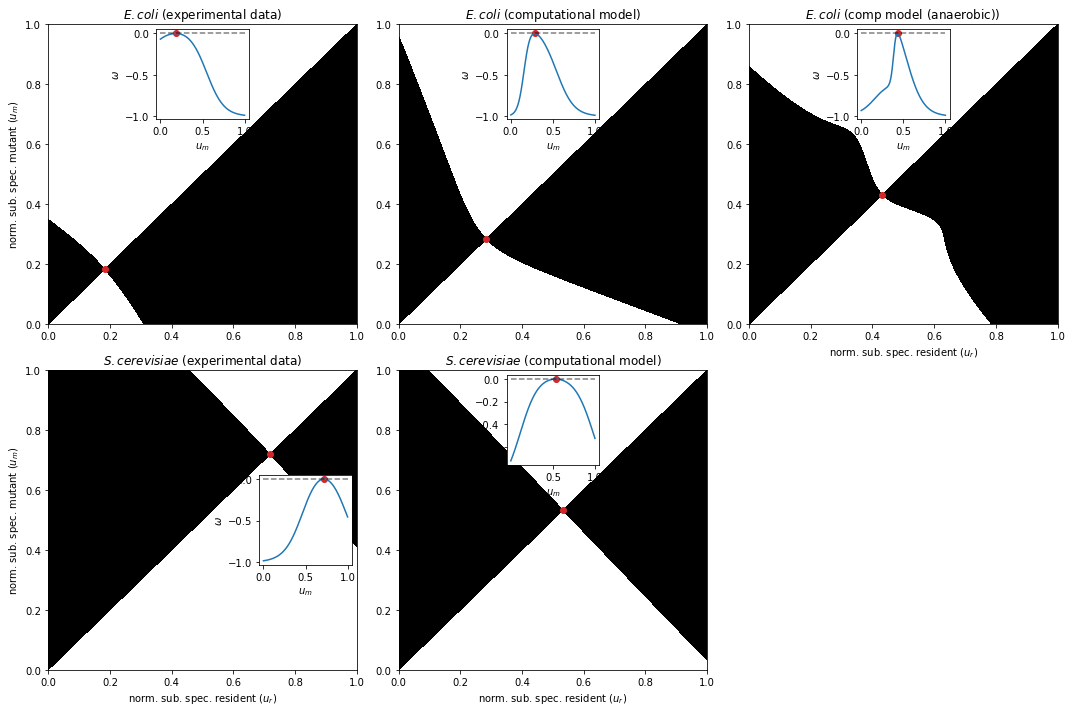

In [29]:
axins = []

fig, ax = plt.subplots(2,3, figsize=(15,10))
for i, pip in enumerate(pips_ecoli):
    ax[0,i].contourf(R, M, pip, levels=[pip.min(),0,pip.max()], colors=['w','k'])
    ax[0,i].scatter(equilibria_ecoli[i],equilibria_ecoli[i],color='C3')
    axins.append(inset_axes(ax[0,i], width="30%", height="30%", loc="upper center"))
    plot_local_landscape(axins[-1], equilibria_ecoli[i], ecoli[i], 0.1375, .5)
    ax[0,i].set(title=ecoli[i].legend)
    

for i, pip in enumerate(pips_yeast):
    ax[1,i].contourf(R, M, pip, levels=[pip.min(),0,pip.max()], colors=['w','k'])
    ax[1,i].scatter(equilibria_yeast[i],equilibria_yeast[i],color='C3')
    if i==0:
        axins.append(inset_axes(ax[1,i], width="30%", height="30%", loc="center right"))
    else:
        axins.append(inset_axes(ax[1,i], width="30%", height="30%", loc="upper center"))
    plot_local_landscape(axins[-1], equilibria_yeast[i], yeast[i], 100, .1)
    ax[1,i].set(title=yeast[i].legend)

ax[0,0].set(ylabel=r'norm. sub. spec. mutant ($u_m$)')
ax[0,2].set(xlabel=r'norm. sub. spec. resident ($u_r$)')
ax[1,0].set(ylabel=r'norm. sub. spec. mutant ($u_m$)', xlabel=r'norm. sub. spec. resident ($u_r$)')
ax[1,1].set(xlabel=r'norm. sub. spec. resident ($u_r$)')
        
ax[1,2].set_visible(False)
        
plt.tight_layout()
#plt.savefig('figures/all_pips.png')

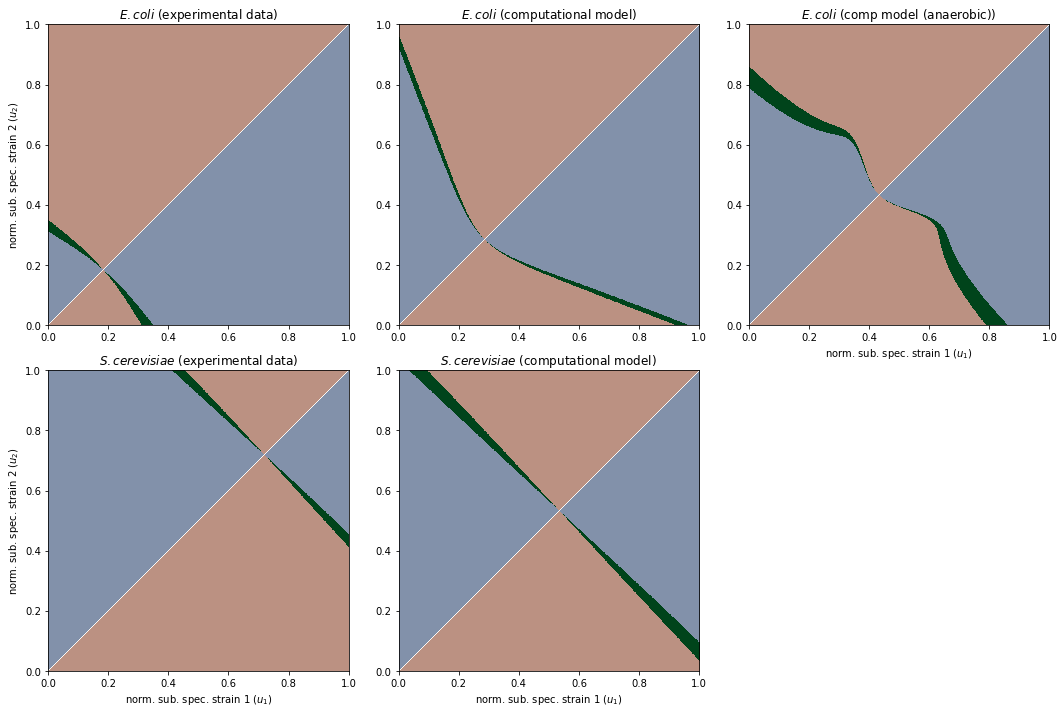

In [30]:
fig,ax = plt.subplots(2,3,figsize=(15,10))

for i, pip in enumerate(pips_ecoli):
    ax[0,i].imshow(pip>0, cmap='Blues', origin='lower', interpolation='none', extent=[0,1,0,1])
    ax[0,i].imshow(np.transpose(pip)>0, cmap='Oranges', origin='lower', interpolation='none', extent=[0,1,0,1],alpha=0.5)
    tep = np.logical_and(np.transpose(pip)>0,pip>0)
    tep = np.ma.masked_where(tep == 0, tep)
    tep[0,0]=0
    ax[0,i].imshow(tep, cmap='Greens', origin='lower', interpolation='none', extent=[0,1,0,1])
    ax[0,i].set(title=ecoli[i].legend)

for i, pip in enumerate(pips_yeast):
    ax[1,i].imshow(pip>0, cmap='Blues', origin='lower', interpolation='none', extent=[0,1,0,1])
    ax[1,i].imshow(np.transpose(pip)>0, cmap='Oranges', origin='lower', interpolation='none', extent=[0,1,0,1],alpha=0.5)
    tep = np.logical_and(np.transpose(pip)>0,pip>0)
    tep = np.ma.masked_where(tep == 0, tep)
    tep[0,0]=0    
    ax[1,i].imshow(tep, cmap='Greens', origin='lower', interpolation='none', extent=[0,1,0,1])
    ax[1,i].set(title=yeast[i].legend)

ax[0,0].set(ylabel=r'norm. sub. spec. strain 2 ($u_2$)')
ax[0,2].set(xlabel=r'norm. sub. spec. strain 1 ($u_1$)')
ax[1,0].set(ylabel=r'norm. sub. spec. strain 2 ($u_2$)', xlabel=r'norm. sub. spec. strain 1 ($u_1$)')
ax[1,1].set(xlabel=r'norm. sub. spec. strain 1 ($u_1$)')

ax[1,2].set_visible(False)
    
plt.tight_layout()
#plt.savefig('figures/all_mips.png')

## Appendix Figure A.10

In [31]:
pips_ecoli_high = []
for sp in ecoli:
    (_, _, temp) = compute_pip(1000, 13.75, .5, sp)
    pips_ecoli_high.append(temp)

In [32]:
equilibria_ecoli_high = []
for sp in ecoli:
    equilibria_ecoli_high.append(find_singular_trait_value(sp, 13.75, .5, 0, 1))

C:\Users\meike\anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


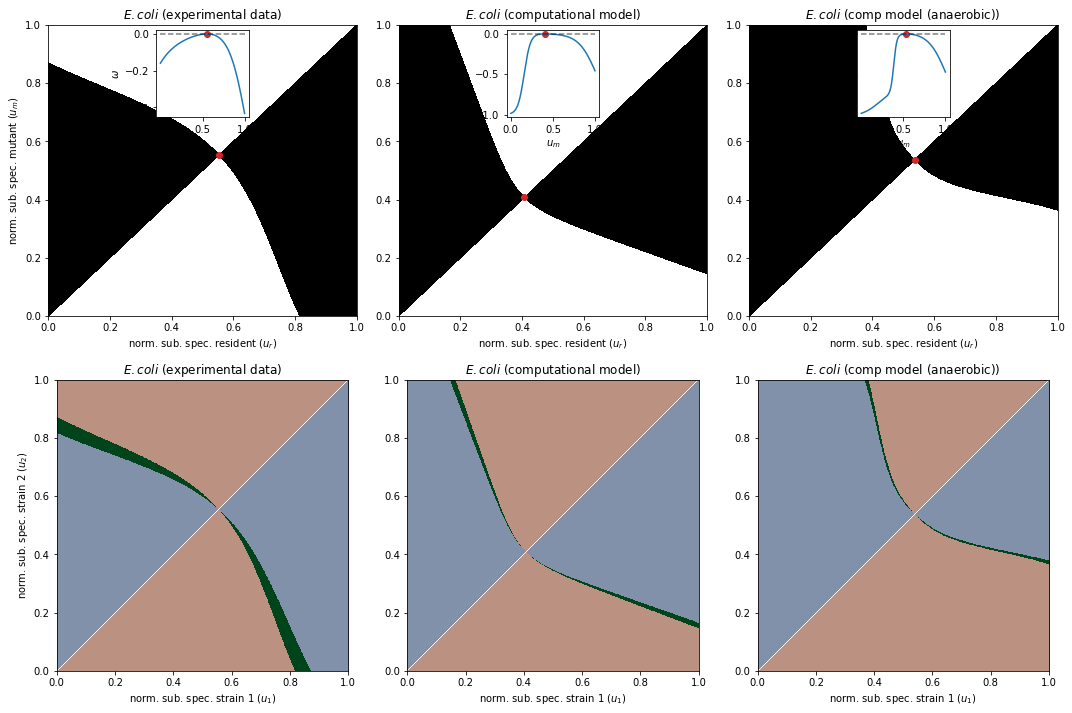

In [35]:
axins = []

fig, ax = plt.subplots(2,3, figsize=(15,10))
for i, pip in enumerate(pips_ecoli_high):
    ax[0,i].contourf(R, M, pip, levels=[pip.min(),0,pip.max()], colors=['w','k'])
    ax[0,i].scatter(equilibria_ecoli_high[i],equilibria_ecoli_high[i],color='C3')
    axins.append(inset_axes(ax[0,i], width="30%", height="30%", loc="upper center"))
    plot_local_landscape(axins[-1], equilibria_ecoli_high[i], ecoli[i], 13.75, .5)
    ax[0,i].set(title=ecoli[i].legend)

ax[0,0].set(ylabel=r'norm. sub. spec. mutant ($u_m$)', xlabel=r'norm. sub. spec. resident ($u_r$)')
ax[0,1].set(xlabel=r'norm. sub. spec. resident ($u_r$)')
ax[0,2].set(xlabel=r'norm. sub. spec. resident ($u_r$)')

for i, pip in enumerate(pips_ecoli_high):
    ax[1,i].imshow(pip>0, cmap='Blues', origin='lower', interpolation='none', extent=[0,1,0,1])
    ax[1,i].imshow(np.transpose(pip)>0, cmap='Oranges', origin='lower', interpolation='none', extent=[0,1,0,1],alpha=0.5)
    tep = np.logical_and(np.transpose(pip)>0,pip>0)
    tep = np.ma.masked_where(tep == 0, tep)
    tep[1,0]=0
    ax[1,i].imshow(tep, cmap='Greens', origin='lower', interpolation='none', extent=[0,1,0,1])
    ax[1,i].set(title=ecoli[i].legend)

ax[1,0].set(ylabel=r'norm. sub. spec. strain 2 ($u_2$)', xlabel=r'norm. sub. spec. strain 1 ($u_1$)')
ax[1,1].set(xlabel=r'norm. sub. spec. strain 1 ($u_1$)')
ax[1,2].set(xlabel=r'norm. sub. spec. strain 1 ($u_1$)')

plt.tight_layout()
#plt.savefig('figures/ecoli_pips_mips_high_initial_substrate.png')